# Identificador de especies arbóreas de Costa Rica.
## Utilizando redes convolucionales artificiales

Se utilizará la arquitectura ViT: Vision Transformer
usando como base un modelo preentrenado debido a los pocos datos para iniciar un modelo desde cero, y además se necesitan más recursos computacionales para entrenar un modelo necesario para iniciar

# Instalación de paquetes necesarios

In [ ]:
import platform
platform.processor()

'x86_64'

In [ ]:
import cpuinfo
#cpuinfo.get_cpu_info() # all information
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Xeon(R) CPU @ 2.20GHz'

In [ ]:
!python --version

Python 3.10.12


In [1]:
import torch
torch.__version__

'2.2.1+cu121'

**torchinfo**: para presentar resumen del modelo

In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
torchinfo.__version__

'1.8.0'

In [ ]:
import torchvision
torchvision.__version__

'0.17.1+cu121'

# Importación de bibliotecas necesarias

In [ ]:
!pip install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import git
import shutil
import os

def clone_git(repo_url, folder, target):
    temp_dir = "temp"
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

    if os.path.exists(target):
        shutil.rmtree(target)

    repo = git.Repo.clone_from(repo_url, temp_dir)

    source = os.path.join(temp_dir, folder)

    shutil.copytree(source, target)

    shutil.rmtree(temp_dir)

repo_url = 'https://github.com/thechancher/Cocobolo-ViT.git'
folder = 'lib'
target = os.path.join(os.getcwd(), folder)

clone_git(repo_url, folder, target)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Asignación de variables globales

La base de datos que se utilizará es de 1289 imágenes:

66% = 1733 imágenes para el entrenamiento (train)

17% = 446 imágenes para la prueba (test)

18% = 464 imágenes para la validación (validation)

In [4]:
import os

dataset_folder = "drive/MyDrive/Colab Notebooks/dataset-cr"
train_dir = dataset_folder + "/train"
test_dir = dataset_folder + "/test"
validate_dir = dataset_folder + "/validate"

#class_labels = {"1":"1-Aspidosperma polyneuron", "2":"2-Araucaria angustifolia", "3":"3-Tabebuia sp.", "4":"4-Cordia goeldiana", "5":"5-Cordia sp.", "6":"6-Hura crepitans", "7":"7-Acrocarpus fraxinifolius", "8":"8-Hymenaea sp.", "9":"9-Peltogyne sp.", "10":"10-Hymenolobium petraeum", "11":"11-Myroxylon balsamum", "12":"12-Dipteryx sp.", "13":"13-Machaerium sp.", "14":"14-Bowdichia sp.", "15":"15-Mimosa scabrella", "16":"16-Cedrelinga catenaeformis", "17":"17-Goupia glabra", "18":"18-Ocotea porosa", "19":"19-Mezilaurus itauba", "20":"20-Laurus nobilis", "21":"21-Bertholethia excelsa", "22":"22-Cariniana estrellensis", "23":"23-Couratari sp.", "24":"24-Carapa guianensis", "25":"25-Cedrela fissilis", "26":"26-Melia azedarach", "27":"27-Swietenia macrophylla", "28":"28-Brosimum paraense", "29":"29-Bagassa guianensis", "30":"30-Virola surinamensis", "31":"31-Eucalyptus sp.", "32":"32-Pinus sp.", "33":"33-Podocarpus lambertii", "35":"35-Balfourodendron riedelianum", "36":"36-Euxylophora paraensis", "37":"37-Micropholis venulosa", "38":"38-Pouteria pachycarpa", "39":"39-Manilkara huberi", "40":"40-Erisma uncinatum", "41":"41-Vochysia sp."}
class_names_raw = {"10":"10-Spondias mombin [Jobo]","100":"100-Brosimum lactescens [Ojoche blanco, (Ojoche, Ojochillo)]","101":"101-Garcinia madruno [Madruno, Manzana amarilla, (Jorco, Limón de montaña, Madroño)]","102":"102-Dialium guianense [Tamarindo de montaña, (Tamarindo)]","104":"104-Calophyllum brasiliense [Cedro María, María ]","106":"106-Stryphnodendron  microstachyum [Vainillo]","107":"107-Simarouba amara [Aceituno]","113":"113-Hampea appendiculata [Burío, (Algodoncillo, Burío blanco)]","114":"114-Vochysia guatemalensis [Mayo, Cebo, Chancho blanco, (Mayo blanco, Chancho)]","115":"115-Clethra costaricensis [Nance macho]","116":"116-Pourouma bicolor [Chumico]","117":"117-Ilex skutchii [Arenillo, Campano, (Campano blanco)]","118":"118-Inga oerstesiana [Cuajiniquil peludo]","119":"119-Myrsine  pellucidopunctata [Ratón, Ratoncillo]","120":"120-Nectandra membranacea [Aguacatillo, (Quizarrá)]","121":"121-Inga chocoensis [Guabo]","122":"122-Lonchocarpus macrophyllum [Chaperno]","125":"125-Pentaclethra macroloba [Gavilán]","126":"126-Prioria copaifera [Cativo]","127":"127-Chloroleucon sp [Casha]","13":"13-Luehea speciosa [Guácimo molenillo, (Guácimo macho, Guácimo)]","131":"131-Prioria sp. nov [Cativo]","135":"135-Tachigali costaricensis [Tostado]","136":"136-Magnolia gloriensis [Anonillo]","137":"137-Cespedesia spathulata [Tabacón, (Cola de pavo)]","138":"138-Ocotea floribunda [Aguacatillo]","139":"139-Bourreria costaricensis [-]","140":"140-Staphylea occidentalis [Sauco, (Sanlorenzo)]","142":"142-Apeiba membranacea [Peine de mico, Botija]","143":"143-Maranthes panamensis [Pejivallito, (Pejibaye)]","144":"144-Drypetes brownii [Piedrilla]","147":"147-Trichospermum galeottii [Guácimo blanco, (Capulín, Jucó blanco)]","148":"148-Parathesis trichogyne [-]","17":"17-Pochota  fendleri [Pochote, Cedro pochote]","18":"18-Samanea saman [Cenízaro, Genízaro]","2":"2-Cedrela odorata [Cedro amargo]","20":"20-Pachira aquatica [Poponjoche, (Cacao cimarrón, Lirio de agua)]","21":"21-Schizolobium paraibuna [Gallinazo]","23":"23-Tabebuia rosea [Roble de Sabana]","25":"25-Sapium glandulosum [Yos]","27":"27-Brosimum alicastrum [Ojoche, Ramón]","28":"28-Bursera simaruba [Indio desnudo, Jiñocuabe, (Caraña)]","29":"29-Pouteria reticulata [Sapotillo]","3":"3-Cordia alliodora [Laurel]","30":"30-Cassia grandis [Carao, (Sandal)]","31":"31-Trichilia pleeana [-]","43":"43-Brosimum utile [Vaco, Lechoso, (Mastate)]","44":"44-Calophyllum mesoamericanum [Cedro María, María ]","45":"45-Carapa guianensis [Cedro bateo, Cedro macho, Caobilla, (Bateo)]","46":"46-Caryocar costaricense [Ajo, Ajillo]","48":"48-Couratari guianensis [Cachimbo hediondo, Copo hediondo, (Campano Blanco)]","49":"49-Dendropanax arboreus [Fosforillo]","5":"5-Enterolobium cyclocarpum [Guanacaste, (Kurú)]","55":"55-Hieronyma alchorneoides [Pilón, Zapatero, (Sangre de toro)]","57":"57-Jacaranda copaia [Gallinazo, (Jacaranda)]","58":"58-Lacmellea panamensis [Leche de vaca, Lagarto negro]","63":"63-Peltogyne purpurea [Nazareno]","65":"65-Poulsenia armata [Mastate, (Calugo, Chilamate espina)]","7":"7-Diphysa americana [Guachepelín]","70":"70-Pterocarpus sp [Sangrillo]","74":"74-Symphonia globulifera [Cerillo, (Botoncillo)]","75":"75-Tapirira guianensis [Manteco, Cedrillo]","77":"77-Terminalia bucidoides [Escobo, Guayabo de charco, (Roble de charco)]","80":"80-Virola koschnyi [Fruta dorada, Fruta dorada real, (Fruta)]","81":"81-Virola sebifera [-]","82":"82-Vitex cooperi [Manú Platano, Cuajada]","83":"83-Vochysia ferruginea [Botarrama, Mayo colorado, (Mayo)]","84":"84-Vochysia gentryi [Ira de agua, (Mayo)]","85":"85-Zanthoxylum ekmanii [Largarto amarillo, Lagarto, (Lagartillo)]","88":"88-Brosimum costaricanum [Ojoche, (Ojoche macho)]","89":"89-Hymenaea osanigraseminae [Guapinol]","9":"9-Hymenaea courbaril [Guapinol]","93":"93-Astronium graveolens [Ron-ron, (Comenegro)]","94":"94-Pseudolmedia spuria [Ojochillo, Ojochillo colorado, (Guapinolillo, Casanegro)]","99":"99-Pouteria filipes [Sapotillo]"}
#class_names_raw = ["0", "2-Cedrela odorata [Cedro amargo]", "3-Cordia alliodora [Laurel]", "5-Enterolobium cyclocarpum [Guanacaste, (Kurú)]", "7-Diphysa americana [Guachepelín]", "9-Hymenaea courbaril [Guapinol]", "10-Spondias mombin [Jobo]", "13-Luehea speciosa [Guácimo molenillo, (Guácimo macho, Guácimo)]", "17-Pochota  fendleri [Pochote, Cedro pochote]", "18-Samanea saman [Cenízaro, Genízaro]", "20-Pachira aquatica [Poponjoche, (Cacao cimarrón, Lirio de agua)]", "21-Schizolobium paraibuna [Gallinazo]", "23-Tabebuia rosea [Roble de Sabana]", "25-Sapium glandulosum [Yos]", "27-Brosimum alicastrum [Ojoche, Ramón]", "28-Bursera simaruba [Indio desnudo, Jiñocuabe, (Caraña)]", "29-Pouteria reticulata [Sapotillo]", "30-Cassia grandis [Carao, (Sandal)]", "31-Trichilia pleeana [-]", "43-Brosimum utile [Vaco, Lechoso, (Mastate)]", "44-Calophyllum mesoamericanum [Cedro María, María ]", "45-Carapa guianensis [Cedro bateo, Cedro macho, Caobilla, (Bateo)]", "46-Caryocar costaricense [Ajo, Ajillo]", "48-Couratari guianensis [Cachimbo hediondo, Copo hediondo, (Campano Blanco)]", "49-Dendropanax arboreus [Fosforillo]", "55-Hieronyma alchorneoides [Pilón, Zapatero, (Sangre de toro)]", "57-Jacaranda copaia [Gallinazo, (Jacaranda)]", "58-Lacmellea panamensis [Leche de vaca, Lagarto negro]", "63-Peltogyne purpurea [Nazareno]", "65-Poulsenia armata [Mastate, (Calugo, Chilamate espina)]", "70-Pterocarpus sp [Sangrillo]", "74-Symphonia globulifera [Cerillo, (Botoncillo)]", "75-Tapirira guianensis [Manteco, Cedrillo]", "77-Terminalia bucidoides [Escobo, Guayabo de charco, (Roble de charco)]", "80-Virola koschnyi [Fruta dorada, Fruta dorada real, (Fruta)]", "81-Virola sebifera [-]", "82-Vitex cooperi [Manú Platano, Cuajada]", "83-Vochysia ferruginea [Botarrama, Mayo colorado, (Mayo)]", "84-Vochysia gentryi [Ira de agua, (Mayo)]", "85-Zanthoxylum ekmanii [Largarto amarillo, Lagarto, (Lagartillo)]", "88-Brosimum costaricanum [Ojoche, (Ojoche macho)]", "89-Hymenaea osanigraseminae [Guapinol]", "93-Astronium graveolens [Ron-ron, (Comenegro)]", "94-Pseudolmedia spuria [Ojochillo, Ojochillo colorado, (Guapinolillo, Casanegro)]", "99-Pouteria filipes [Sapotillo]", "100-Brosimum lactescens [Ojoche blanco, (Ojoche, Ojochillo)]", "101-Garcinia madruno [Madruno, Manzana amarilla, (Jorco, Limón de montaña, Madroño)]", "102-Dialium guianense [Tamarindo de montaña, (Tamarindo)]", "104-Calophyllum brasiliense [Cedro María, María ]", "106-Stryphnodendron  microstachyum [Vainillo]", "107-Simarouba amara [Aceituno]", "113-Hampea appendiculata [Burío, (Algodoncillo, Burío blanco)]", "114-Vochysia guatemalensis [Mayo, Cebo, Chancho blanco, (Mayo blanco, Chancho)]", "115-Clethra costaricensis [Nance macho]", "116-Pourouma bicolor [Chumico]", "117-Ilex skutchii [Arenillo, Campano, (Campano blanco)]", "118-Inga oerstesiana [Cuajiniquil peludo]", "119-Myrsine  pellucidopunctata [Ratón, Ratoncillo]", "120-Nectandra membranacea [Aguacatillo, (Quizarrá)]", "121-Inga chocoensis [Guabo]", "122-Lonchocarpus macrophyllum [Chaperno]", "125-Pentaclethra macroloba [Gavilán]", "126-Prioria copaifera [Cativo]", "127-Chloroleucon sp [Casha]", "131-Prioria sp. nov [Cativo]", "135-Tachigali costaricensis [Tostado]", "136-Magnolia gloriensis [Anonillo]", "137-Cespedesia spathulata [Tabacón, (Cola de pavo)]", "138-Ocotea floribunda [Aguacatillo]", "139-Bourreria costaricensis [-]", "140-Staphylea occidentalis [Sauco, (Sanlorenzo)]", "142-Apeiba membranacea [Peine de mico, Botija]", "143-Maranthes panamensis [Pejivallito, (Pejibaye)]", "144-Drypetes brownii [Piedrilla]", "147-Trichospermum galeottii [Guácimo blanco, (Capulín, Jucó blanco)]", "148-Parathesis trichogyne [-]"]
print("class_names_raw")
print(class_names_raw)

#class_names = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '35', '36', '37', '38', '39', '4', '40', '41', '5', '6', '7', '8', '9']
class_names = ["10","100","101","102","104","106","107","113","114","115","116","117","118","119","120","121","122","125","126","127","13","131","135","136","137","138","139","140","142","143","144","147","148","17","18","2","20","21","23","25","27","28","29","3","30","31","43","44","45","46","48","49","5","55","57","58","63","65","7","70","74","75","77","80","81","82","83","84","85","88","89","9","93","94","99"]
print("class names")
print(class_names)

print("train classes")
#class_names = os.listdir(train_dir)
print(class_names)

print("test classes")
print(class_names)

print("validation classes")
print(class_names)

model_name = "model-cr-pre-100ep.pth"
model_drive = "drive/MyDrive/Colab Notebooks/model"
model_epochs = 100

class_names_raw
{'10': '10-Spondias mombin [Jobo]', '100': '100-Brosimum lactescens [Ojoche blanco, (Ojoche, Ojochillo)]', '101': '101-Garcinia madruno [Madruno, Manzana amarilla, (Jorco, Limón de montaña, Madroño)]', '102': '102-Dialium guianense [Tamarindo de montaña, (Tamarindo)]', '104': '104-Calophyllum brasiliense [Cedro María, María ]', '106': '106-Stryphnodendron  microstachyum [Vainillo]', '107': '107-Simarouba amara [Aceituno]', '113': '113-Hampea appendiculata [Burío, (Algodoncillo, Burío blanco)]', '114': '114-Vochysia guatemalensis [Mayo, Cebo, Chancho blanco, (Mayo blanco, Chancho)]', '115': '115-Clethra costaricensis [Nance macho]', '116': '116-Pourouma bicolor [Chumico]', '117': '117-Ilex skutchii [Arenillo, Campano, (Campano blanco)]', '118': '118-Inga oerstesiana [Cuajiniquil peludo]', '119': '119-Myrsine  pellucidopunctata [Ratón, Ratoncillo]', '120': '120-Nectandra membranacea [Aguacatillo, (Quizarrá)]', '121': '121-Inga chocoensis [Guabo]', '122': '122-Lonchocarpus

# Dimensiones, Patches y Batches

In [ ]:
batch_size = 32
image_size = 224
patch_size = 16
rgb = 3
patches = patch_size * patch_size * rgb # 768
# number of patches = 192 = (height * width) / patch^2 = (image_size * image_size) / patch_size ^2
print(patches)

768


# Selección de Tarjeta Gráfica o CPU

In [ ]:
import torch
import tensorflow as tf

use_cuda = torch.cuda.is_available()
if use_cuda:
  device = "cuda:0"
  print('CUDNN VERSION:', torch.backends.cudnn.version())
  print('Number CUDA Devices:', torch.cuda.device_count())
  print('CUDA Device Name:',torch.cuda.get_device_name(0))
  print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
  print('GPU name:', tf.test.gpu_device_name())
else:
  device = "cpu"
  print("No GPU available")

print("Device:", device)

CUDNN VERSION: 8906
Number CUDA Devices: 1
CUDA Device Name: NVIDIA L4
CUDA Device Total Memory [GB]: 23.802544128
GPU name: /device:GPU:0
Device: cuda:0


# Obtención de modelo pre-entrenado

El modelo pre-entrenado seleccionado es: **ViT_B_16_Weights**

In [ ]:
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
from torch import nn

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=patches, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

# Preparación del modelo pre-entrenado

Como se observa en el output, se confirma que las primeras capas no se entrenarán puesto que el el código anterior se congelaron las capas del modelo pre-entrenado

**Trainable = False**

sólo la capa final linear se entrenará

**Linear = True**

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 75]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Trasladar las imágenes a DataLoader para que sea recibido por la red neuronal

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Turn images into data loaders

  # Train dataset
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )

  # Test dataset
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Create data loaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=batch_size)

In [ ]:
train_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 1735
    Root location: drive/MyDrive/Colab Notebooks/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [ ]:
test_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 446
    Root location: drive/MyDrive/Colab Notebooks/dataset-cr/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

# Check Dataset

In [ ]:
# Let's visualize a image in order to know if data is loaded properly or not

# !pip install numpy
# import numpy
# Get a batch of images
dataset_t = train_dataloader_pretrained.dataset
#random_index = int(numpy.random.random()*len(dataset_t))
#random_index = 1106 # must be: 48-Couratari guianensis [Cachimbo hediondo, Copo hediondo, (Campano Blanco)]
random_index = 593 # must be: 148-Parathesis trichogyne [-]
random_example, random_label = dataset_t[random_index]
print(random_label)
print(random_example.shape)

print(class_labels[class_names[random_label]])

32
torch.Size([3, 224, 224])
148-Parathesis trichogyne [-]


# Entrenar la red usando el dataloader

In [ ]:
from lib import engine

import time
start_time = time.time()

# Create optimizer and loss function
learnable_rate = 1e-3
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=learnable_rate,
                             weight_decay=0.3 # from the ViT 4.1
                             )
# loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()

# model.train() ##
training_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=model_epochs,
                                      device=device)

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 2.8298 | train_acc: 0.4280 | test_loss: 3.0587 | test_acc: 0.3403
Epoch: 2 | train_loss: 2.7202 | train_acc: 0.4543 | test_loss: 3.0567 | test_acc: 0.3381
Epoch: 3 | train_loss: 2.7393 | train_acc: 0.4374 | test_loss: 3.0339 | test_acc: 0.3579
Epoch: 4 | train_loss: 2.7129 | train_acc: 0.4684 | test_loss: 3.0458 | test_acc: 0.3714
Epoch: 5 | train_loss: 2.7120 | train_acc: 0.4499 | test_loss: 3.0638 | test_acc: 0.3466
Epoch: 6 | train_loss: 2.6869 | train_acc: 0.4719 | test_loss: 3.0229 | test_acc: 0.3482
Epoch: 7 | train_loss: 2.7307 | train_acc: 0.4402 | test_loss: 3.0208 | test_acc: 0.3780
Epoch: 8 | train_loss: 2.7291 | train_acc: 0.4506 | test_loss: 3.0125 | test_acc: 0.3799
Epoch: 9 | train_loss: 2.7148 | train_acc: 0.4428 | test_loss: 3.0522 | test_acc: 0.3652
Epoch: 10 | train_loss: 2.6978 | train_acc: 0.4544 | test_loss: 3.0694 | test_acc: 0.3089
Epoch: 11 | train_loss: 2.6900 | train_acc: 0.4844 | test_loss: 3.0294 | test_acc: 0.3295
Epoch: 12 | train_l

In [ ]:
# export the model
torch.save(pretrained_vit, model_name)
shutil.copy2(model_name, model_drive)

'drive/MyDrive/Colab Notebooks/model/model-pre-100ep-cr.pth'

In [ ]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
pretrained_vit.heads

Linear(in_features=768, out_features=75, bias=True)

# Graficas de error

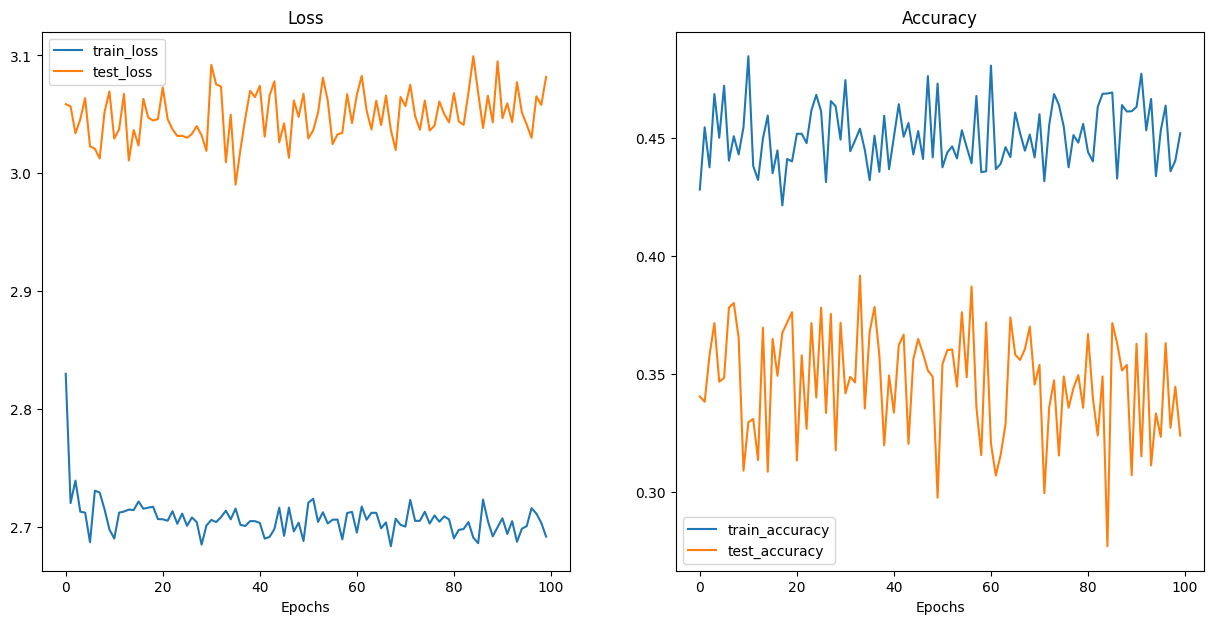

In [ ]:
from lib.helper_functions import plot_loss_curves

# Plot ViT model's loss curves
plot_loss_curves(training_results)

# Preparación de prueba del ViT

In [5]:
# Setup custom image path
class_test = "17"
file_test = "3656"
test_dir = validate_dir + "/" + class_test + "/" + file_test + ".jpg"

# Ejecutar predicción usando el modelo entrenado

Class:
17
Probability
tensor(0.1667, device='cuda:0')
Probability
tensor([[0.0390, 0.0013, 0.0044, 0.0022, 0.0127, 0.0074, 0.0068, 0.0044, 0.0066,
         0.0014, 0.0108, 0.0033, 0.0172, 0.0036, 0.0050, 0.0265, 0.0044, 0.0104,
         0.0031, 0.0036, 0.0031, 0.0302, 0.0108, 0.0047, 0.0032, 0.0106, 0.0048,
         0.0033, 0.0494, 0.0092, 0.0060, 0.0273, 0.0046, 0.1667, 0.0096, 0.0490,
         0.0074, 0.0101, 0.0044, 0.0446, 0.0023, 0.0050, 0.0016, 0.0024, 0.0059,
         0.0014, 0.0161, 0.0271, 0.0244, 0.0265, 0.0098, 0.0021, 0.0103, 0.0166,
         0.0296, 0.0034, 0.0043, 0.0096, 0.0028, 0.0031, 0.0068, 0.0190, 0.0048,
         0.0130, 0.0072, 0.0098, 0.0318, 0.0197, 0.0025, 0.0066, 0.0133, 0.0080,
         0.0158, 0.0025, 0.0015]], device='cuda:0')


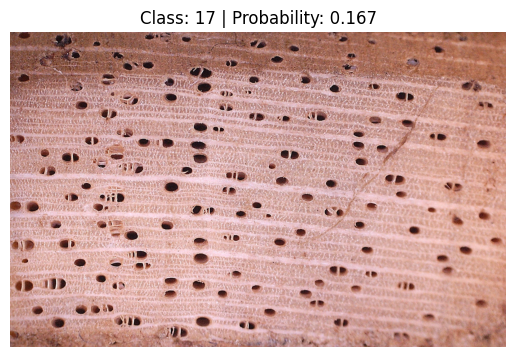

In [ ]:
# import requests

# Import function to make predictions on images and plot them
from lib.predictions import pred_and_plot_image

# Predict on custom image
# must be: 'index': 33, 'name': '17', 'label': '17-Pochota  fendleri [Pochote, Cedro pochote]'
pred_and_plot_image(model=pretrained_vit,
                    image_path=test_dir,
                    class_names=class_names)

# Ejecutar predicción usando el modelo entrenado exportado

In [6]:
import os
import shutil

#model_name = "model-cr-pre-100ep-32.pth"
model_source = os.path.join(model_drive, model_name)
shutil.copy2(model_source, model_name)

'model-cr-pre-100ep-32.pth'

Class:
17

Probability
tensor(0.1667, device='cuda:0')

Probabilities
tensor([[0.0390, 0.0013, 0.0044, 0.0022, 0.0127, 0.0074, 0.0068, 0.0044, 0.0066,
         0.0014, 0.0108, 0.0033, 0.0172, 0.0036, 0.0050, 0.0265, 0.0044, 0.0104,
         0.0031, 0.0036, 0.0031, 0.0302, 0.0108, 0.0047, 0.0032, 0.0106, 0.0048,
         0.0033, 0.0494, 0.0092, 0.0060, 0.0273, 0.0046, 0.1667, 0.0096, 0.0490,
         0.0074, 0.0101, 0.0044, 0.0446, 0.0023, 0.0050, 0.0016, 0.0024, 0.0059,
         0.0014, 0.0161, 0.0271, 0.0244, 0.0265, 0.0098, 0.0021, 0.0103, 0.0166,
         0.0296, 0.0034, 0.0043, 0.0096, 0.0028, 0.0031, 0.0068, 0.0190, 0.0048,
         0.0130, 0.0072, 0.0098, 0.0318, 0.0197, 0.0025, 0.0066, 0.0133, 0.0080,
         0.0158, 0.0025, 0.0015]], device='cuda:0')

Sorted:
sorted: torch.return_types.sort(
values=tensor([[0.1667, 0.0494, 0.0490, 0.0446, 0.0390, 0.0318, 0.0302, 0.0296, 0.0273,
         0.0271, 0.0265, 0.0265, 0.0244, 0.0197, 0.0190, 0.0172, 0.0166, 0.0161,
         0.0158, 0.

[{'index': 33,
  'name': '17',
  'label': '17-Pochota  fendleri [Pochote, Cedro pochote]',
  'prob': 0.16671113669872284},
 {'index': 28,
  'name': '142',
  'label': '142-Apeiba membranacea [Peine de mico, Botija]',
  'prob': 0.04935481399297714},
 {'index': 35,
  'name': '2',
  'label': '2-Cedrela odorata [Cedro amargo]',
  'prob': 0.048959460109472275},
 {'index': 39,
  'name': '25',
  'label': '25-Sapium glandulosum [Yos]',
  'prob': 0.04457460716366768},
 {'index': 0,
  'name': '10',
  'label': '10-Spondias mombin [Jobo]',
  'prob': 0.03903704881668091}]

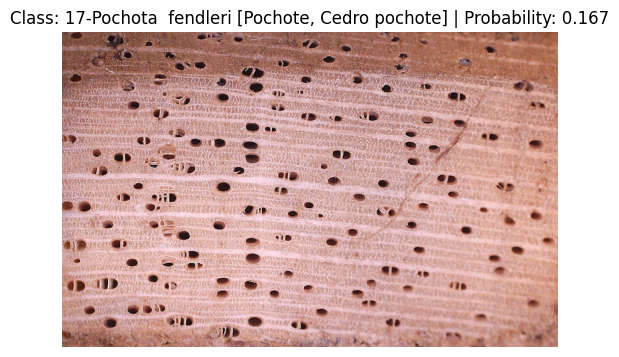

In [7]:
import torch
# import requests

# Import function to make predictions on images and plot them
from lib.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = test_dir
model = torch.load(model_name)
model.eval()

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    class_labels=class_names_raw)